<a href="https://www.kaggle.com/code/ritvik1909/named-entity-recognition-attention" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Named Entity Recognition (NER)

NER is an information extraction technique to identify and classify named entities in text. These entities can be pre-defined and generic like location names, organizations, time and etc, or they can be very specific like the example with the resume.

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

* B - {CHUNK_TYPE} – for the word in the Beginning chunk
* I - {CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

## Approaches to NER
* **Classical Approaches:** mostly rule-based.
* **Machine Learning Approaches:** there are two main methods in this category: 
    * Treat the problem as a multi-class classification where named entities are our labels so we can apply different classification algorithms. The problem here is that identifying and labeling named entities require thorough understanding of the context of a sentence and sequence of the word labels in it, which this method ignores that.
    * Conditional Random Field (CRF) model. It is a probabilistic graphical model that can be used to model sequential data such as labels of words in a sentence. The CRF model is able to capture the features of the current and previous labels in a sequence but it cannot understand the context of the forward labels; this shortcoming plus the extra feature engineering involved with training a CRF model, makes it less appealing to be adapted by the industry.
* **Deep Learning Approaches:** Bidirectional RNNs, Transformers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

plt.style.use('fivethirtyeight')

# Getting the Dataset and EDA

We will be working on S800 Corpus, which is a novel abstract-based manually annotated corpus. S800 comprises 800 PubMed abstracts in which organism mentions were identified and mapped to the corresponding NCBI Taxonomy identifiers.

It is available on Hugging Face Datasets Hub

In [3]:
dataset = load_dataset('species_800')

train_df = pd.DataFrame(dataset['train']).explode(['tokens', 'ner_tags']).dropna()
valid_df = pd.DataFrame(dataset['validation']).explode(['tokens', 'ner_tags']).dropna()
test_df = pd.DataFrame(dataset['test']).explode(['tokens', 'ner_tags']).dropna()

In [4]:
train_df.head()

,id,tokens,ner_tags
0,0,Methanoregula,1
0,0,formicica,2
0,0,sp,0
0,0,.,0
0,0,nov,0


Here ner_tag 1 indicates B
and ner_tag 2 indicates I
while ner_tag 0 indicates O

for simplicity we will combine B and I

In [5]:
train_df['ner_tags'] = train_df['ner_tags'].apply(lambda x: 1 if x > 0 else 0)
valid_df['ner_tags'] = valid_df['ner_tags'].apply(lambda x: 1 if x > 0 else 0)
test_df['ner_tags'] = test_df['ner_tags'].apply(lambda x: 1 if x > 0 else 0)

**Create list of list of tuples to differentiate each sentence from each other**

In [6]:
class SentenceGetter(object):
    
    def __init__(self, dataset, word_col, tag_col, sent_id_col):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [
            (w, t) for w,t in zip(s[word_col].values.tolist(), s[tag_col].values.tolist())
        ]
        self.grouped = self.dataset.groupby(sent_id_col).apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
train_getter = SentenceGetter(dataset=train_df, word_col='tokens', tag_col='ner_tags', sent_id_col='id')
valid_getter = SentenceGetter(dataset=valid_df, word_col='tokens', tag_col='ner_tags', sent_id_col='id')
test_getter = SentenceGetter(dataset=test_df, word_col='tokens', tag_col='ner_tags', sent_id_col='id')

train_sentences = train_getter.sentences
valid_sentences = valid_getter.sentences
test_sentences = test_getter.sentences
print('Sample Sentence')
print(train_sentences[0])

Sample Sentence
[('Methanoregula', 1), ('formicica', 1), ('sp', 0), ('.', 0), ('nov', 0), ('.', 0), (',', 0), ('a', 0), ('methane', 0), ('-', 0), ('producing', 0), ('archaeon', 0), ('isolated', 0), ('from', 0), ('methanogenic', 0), ('sludge', 0), ('.', 0)]


Number of Sentences: 5733
Maximum sequence length: 132
Number of unique words: 14267


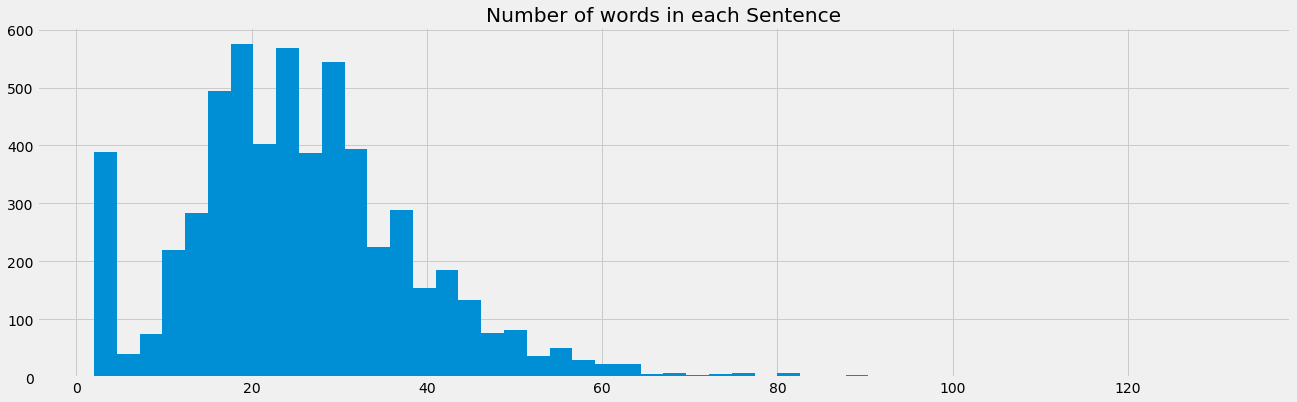

In [8]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in train_sentences], bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = max([len(s) for s in train_sentences])
print('Number of Sentences:', len(train_sentences))
print ('Maximum sequence length:', maxlen)

words = list(set(train_df["tokens"].values))
words.append("ENDPAD")
words.append("UNK")
n_words = len(words)
print('Number of unique words:', n_words)

**Converting words to numbers and numbers to words**

In [9]:
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for i, w in enumerate(words)}

# Modelling

In [10]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical

**Lets first tokenize the data**

In [11]:
X_train = [[word2idx.get(w[0], len(word2idx)-1) for w in s] for s in train_sentences]
X_train = sequence.pad_sequences(maxlen=maxlen, sequences=X_train, padding="post",value=n_words - 2)

y_train = [[[w[1]] for w in s] for s in train_sentences]
y_train = sequence.pad_sequences(maxlen=maxlen, sequences=y_train, padding="post", value=0)
y_train = np.array([to_categorical(i, num_classes=2) for i in y_train])

print('X shape', X_train.shape, 'y shape', y_train.shape)

X shape (5733, 132) y shape (5733, 132, 2)


In [12]:
X_valid = [[word2idx.get(w[0], len(word2idx)-1) for w in s] for s in valid_sentences]
X_valid = sequence.pad_sequences(maxlen=maxlen, sequences=X_valid, padding="post",value=n_words - 2)

y_valid = [[[w[1]] for w in s] for s in valid_sentences]
y_valid = sequence.pad_sequences(maxlen=maxlen, sequences=y_valid, padding="post", value=0)
y_valid = np.array([to_categorical(i, num_classes=2) for i in y_valid])

print('X shape', X_valid.shape, 'y shape', y_valid.shape)

X shape (830, 132) y shape (830, 132, 2)


In [13]:
X_test = [[word2idx.get(w[0], len(word2idx)-1) for w in s] for s in test_sentences]
X_test = sequence.pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=n_words - 2)

y_test = [[[w[1]] for w in s] for s in test_sentences]
y_test = sequence.pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=0)
y_test = np.array([to_categorical(i, num_classes=2) for i in y_test])

print('X shape', X_test.shape, 'y shape', y_test.shape)

X shape (1630, 132) y shape (1630, 132, 2)


**Training Parameters**

In [14]:
class config():
    VOCAB = n_words
    MAX_LEN = maxlen
    N_OUPUT = 2
    
    
    EMBEDDING_VECTOR_LENGTH = 50
    DENSE_DIM = 32
    NUM_HEADS = 2
    
    OUTPUT_ACTIVATION = 'softmax'
    
    LOSS = 'categorical_crossentropy'
    OPTIMIZER = 'adam'
    METRICS = ['accuracy']
    
    MAX_EPOCHS = 100

**Lets define a standard Transformer Encoder Block**

In [15]:
class TransformerEncoder(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([L.Dense(dense_dim, activation='relu'), L.Dense(embed_dim)])
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_confog()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config    

**Some standard Callbacks**

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
rlp = ReduceLROnPlateau(monitor='loss', patience=3)
csv_logger = CSVLogger('training_log.csv')

**Lets define our model**

A token classification is pretty simple and similar to that of sequence classification, ie there is only one change, since we need predictions for each input tokken we do not use the Global Pooling Layer, therefore the architechture looks something like:
* Input Layer
* Embeddings
* Transformer Encoder Block
* Dropout (optional)
* Classification Layer (where n_units = number of classes, ie 2 in out case)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          713350    
                                                                 
 transformer_encoder (Transf  (None, None, 50)         23832     
 ormerEncoder)                                                   
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 dense_2 (Dense)             (None, None, 2)           102       
                                                                 
Total params: 737,284
Trainable params: 737,284
Non-trainable params: 0
_______________________________________________________

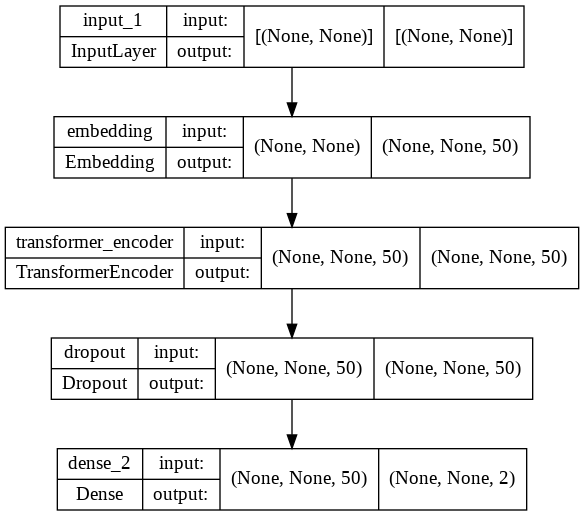

In [17]:
inputs = keras.Input(shape=(None, ), dtype="int64")
x = L.Embedding(config.VOCAB, config.EMBEDDING_VECTOR_LENGTH)(inputs)
x = TransformerEncoder(config.EMBEDDING_VECTOR_LENGTH, config.DENSE_DIM, config.NUM_HEADS)(x)
x = L.Dropout(0.5)(x)
outputs = L.Dense(config.N_OUPUT, activation=config.OUTPUT_ACTIVATION)(x)

model = keras.Model(inputs, outputs)
model.compile(loss=config.LOSS, optimizer=config.OPTIMIZER, metrics=config.METRICS)

model.summary()
plot_model(model, show_shapes=True)

In [18]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
    callbacks=[es, rlp, csv_logger], epochs=config.MAX_EPOCHS
)

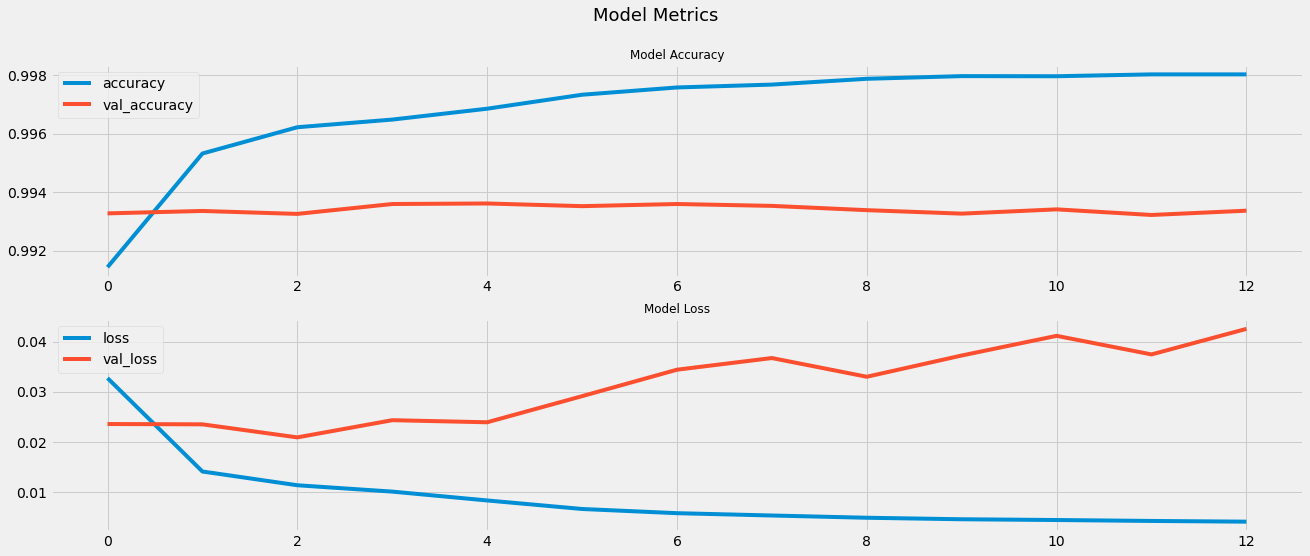

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

# Evaluation

In [20]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y_test, axis=-1)[i]

print(f"{'Word':15}{'True':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X_test[i], y_true, p[0]):
    print(f"{words[w]:15}{t}\t{pred}")
    if words[w] == 'ENDPAD': 
        break

Word           True 	Pred
------------------------------
We             0	0
have           0	0
studied        0	0
fluctuations   0	0
in             0	0
a              0	0
population     0	0
of             0	0
the            0	0
white          1	1
-              1	0
throated       1	1
dipper         1	0
Cinclus        1	1
cinclus        1	1
during         0	0
31             0	0
years          0	0
(              0	0
1978           0	0
-              0	0
2008           0	0
)              0	0
in             0	0
a              0	0
river          0	0
system         0	0
in             0	0
southern       0	0
Norway         0	1
in             0	0
relation       0	0
to             0	0
both           0	0
large          0	0
-              0	0
scale          0	0
and            0	0
local          0	0
weather        0	0
conditions     0	0
occurring      0	0
during         0	0
the            0	0
non            0	0
-              0	0
breeding       0	0
season         0	0
.              0	0
ENDPAD      